# Feature Engineering and Modeling

**Notebook Objectives** <br>
- Build predictive models to estimate the probability of customer subscription
- Compare different machine learning algorithms (Logistic Regression, Random Forest, LightGBM, XGBoost) under various sampling strategies
- Select the most effective model based on accuracy, F1-score, recall, and AUC

**Notebook Structure** <br>
1. Importing Libraries
2. Data Loading, Overview and cleaning
3. Feature Engineering
4. Modeling & Training
5. Selecting best model
   

## Importing Libraries

In [1]:
# System & utils
import sys, os
notebook_dir = os.path.dirname(os.getcwd())
sys.path.append(notebook_dir)
from utils import data_cleaning, feature_engineering, modeling

# Data
import pandas as pd
import numpy as np
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import make_scorer, f1_score


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb
import lightgbm as lgb

# Imbalanced-learn
from imblearn.over_sampling import SMOTE, SMOTENC 
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


## Data Loading, Overview and cleaning

--- Dataset Overview ---
Shape: (45211, 16)
Memory Usage: 22.35 MB
Duplicate Rows: 0

--- Missing Values ---
- Age: 0 missing values
- Job: 288 missing values
- Marital: 0 missing values
- Education: 1857 missing values
- Default: 0 missing values
- Balance: 0 missing values
- Housing: 0 missing values
- Loan: 0 missing values
- Contact: 13020 missing values
- Day_of_week: 0 missing values
- Month: 0 missing values
- Duration: 0 missing values
- Campaign: 0 missing values
- Pdays: 0 missing values
- Previous: 0 missing values
- Poutcome: 36959 missing values

--- Data Types ---
- object: 9 columns
- int64: 7 columns

--- Outlier Counts ---
- Age: 381 outliers
- Balance: 745 outliers
- Day_of_week: 0 outliers
- Duration: 963 outliers
- Campaign: 840 outliers
- Pdays: 1723 outliers
- Previous: 582 outliers


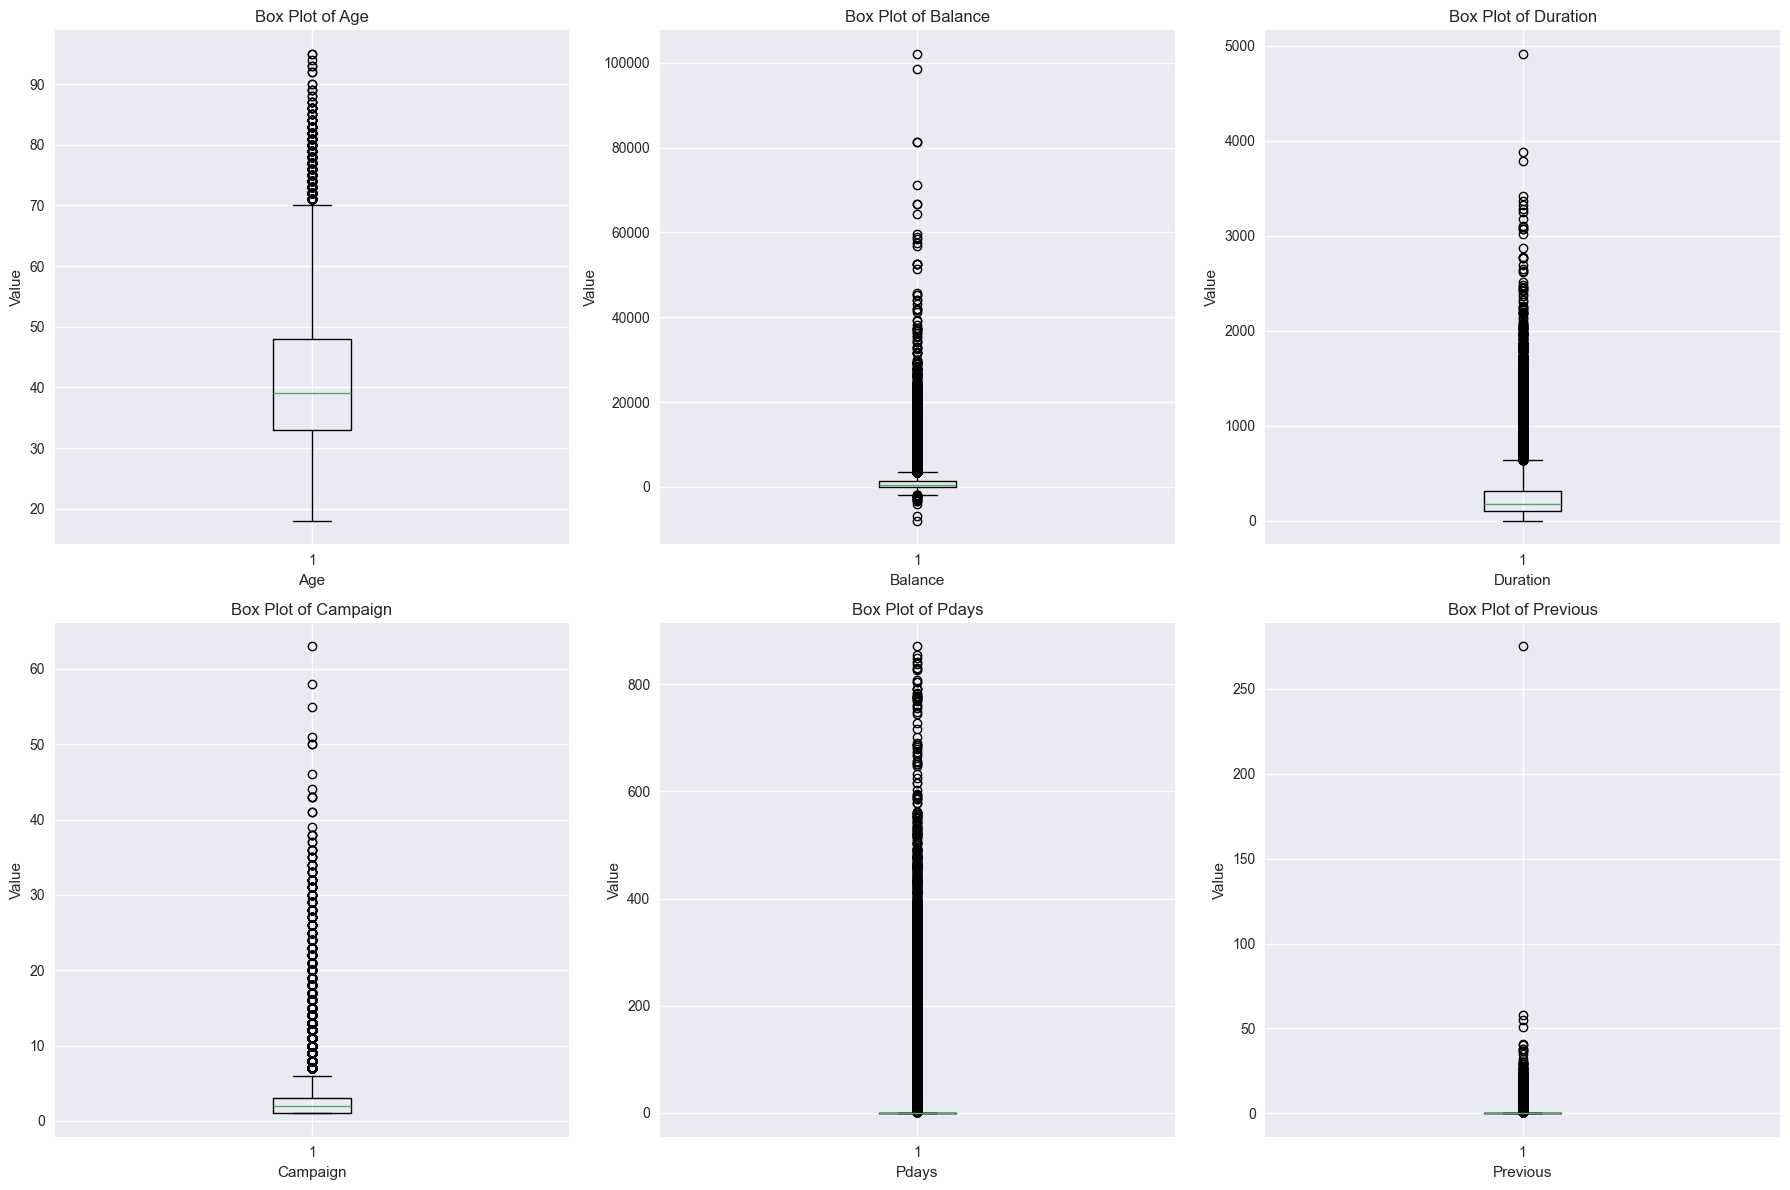

['Capped 13 campaign outliers at 40']


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 

X = bank_marketing.data.features
y = bank_marketing.data.targets

y = y['y']
y = y.map({'no': 0, 'yes': 1})


raw_original_dataset = bank_marketing.data.original
original_dataset = data_cleaning.complete_data_cleaning_pipeline(X)

In [3]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          45211 non-null  object
 2   marital      45211 non-null  object
 3   education    45211 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      45211 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     45211 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.5+ MB


## Feature Engineering

In [4]:
original_dataset_clean = feature_engineering.create_feature_engineering_pipeline(original_dataset)

final_features:['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'age_group', 'is_professional', 'education_level', 'balance_category', 'balance_per_age', 'has_credit_risk', 'call_efficiency', 'was_contacted_before', 'contact_recency', 'prev_campaign_success', 'high_contact_intensity', 'month_numeric', 'is_q1', 'is_summer', 'is_q4', 'mature_educated', 'duration_prev_success', 'customer_value_score', 'is_high_value', 'customer_stability', 'duration_percentile', 'optimal_duration', 'campaign_fatigue', 'campaign_above_median', 'contact_effectiveness', 'prev_success_rate', 'risk_appetite', 'financial_engagement', 'financial_planning_season', 'tax_season', 'vacation_season', 'balance_vs_expected', 'above_expected_wealth', 'education_job_alignment', 'quality_strategy', 'young_professional', 'established_family']
features_added: 37


In [5]:
original_dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   age                        45211 non-null  int64   
 1   job                        45211 non-null  object  
 2   marital                    45211 non-null  object  
 3   education                  45211 non-null  object  
 4   default                    45211 non-null  object  
 5   balance                    45211 non-null  int64   
 6   housing                    45211 non-null  object  
 7   loan                       45211 non-null  object  
 8   contact                    45211 non-null  object  
 9   day_of_week                45211 non-null  int64   
 10  month                      45211 non-null  object  
 11  duration                   45211 non-null  int64   
 12  campaign                   45211 non-null  int64   
 13  pdays                      4521

In [6]:
X = original_dataset_clean

## Modeling

#### TRAIN-TEST SPLIT & FEATURE SCALING

In [7]:
# Random seed
RANDOM_STATE = 42

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Training class distribution: {y_train.value_counts().to_dict()}")



print('\nSaving the test sets for later...')
print(f"Test class distribution: {y_test.value_counts().to_dict()}")
with open("../Models/X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)
    print("X_test save to path: ../Models/X_test.pkl")
with open("../Models/y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)
    print("y_test save to path: ../Models/y_test.pkl")

Training set: 36,168 samples
Test set: 9,043 samples
Training class distribution: {0: 31937, 1: 4231}

Saving the test sets for later...
Test class distribution: {0: 7985, 1: 1058}
X_test save to path: ../Models/X_test.pkl
y_test save to path: ../Models/y_test.pkl


#### MODEL DEVELOPMENT & COMPARISON

In [25]:
# Configuration
RANDOM_STATE = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
f1_scorer = make_scorer(f1_score)

# Sampling strategies
sampling_methods = ['No Sampling', 'SMOTE', 'Undersampling']

# Define models and hyperparameter grids

models = {
    'Logistic Regression': (
        LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=500),
        {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']},
        True,   # scaling
        'onehot'  # encoding
    ),
    'Random Forest': (
        RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
        {'n_estimators': [100, 300], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5],
         'min_samples_leaf': [1, 2], 'max_features': ['sqrt', 'log2']},
        False,  # no scaling
        'label'
    ),
    'LightGBM': (
        lgb.LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced', verbose=-1),
        {'num_leaves': [31, 50, 70], 'max_depth': [-1, 5, 10], 'learning_rate': [0.01, 0.05, 0.1],
         'n_estimators': [100, 300], 'min_child_samples': [10, 20, 30], 'subsample': [0.6, 0.8, 1.0],
         'colsample_bytree': [0.6, 0.8, 1.0]},
        False,
        'label'
    ),
    'XGBoost': (
        xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'),
        {'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 300],
         'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0],
         'gamma': [0, 1], 'min_child_weight': [1, 5]},
        False,
        'label'
    )
}


all_results = {}


In [26]:
for sampling in sampling_methods:
    print(f"\n===== Sampling: {sampling} =====")
    
    model_results = {}
    
    for name, (model, param_grid, needs_scaling, encoding_method) in models.items():
        print(f"Tuning {name}...")

        # Encode categorical features
        X_train_enc = modeling.encode_categorical_features(X_train, method=encoding_method)
        X_test_enc = modeling.encode_categorical_features(X_test, method=encoding_method)
        
        # Scale if needed
        X_train_proc, X_test_proc, scaler_obj  = modeling.scale_data(X_train_enc, X_test_enc, apply_scaling=needs_scaling)

       
        if sampling == "No Sampling":
            X_train_res, y_train_res = X_train_proc, y_train
        
        elif sampling == "SMOTE":
            X_train_res, y_train_res = SMOTE(random_state=RANDOM_STATE).fit_resample(X_train_proc, y_train)
        
        
        elif sampling == "Undersampling":
            X_train_res, y_train_res = RandomUnderSampler(random_state=RANDOM_STATE).fit_resample(X_train_proc, y_train)
        
        
        # Hyperparameter tuning
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            n_iter=20,
            scoring=f1_scorer,
            cv=cv,
            verbose=0,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        search.fit(X_train_res, y_train_res)
        best_model = search.best_estimator_
        
        # Predict probabilities on test set
        y_proba = best_model.predict_proba(X_test_proc)[:, 1]
        
        # Threshold optimization for best F1
        thresholds = np.arange(0.1, 0.9, 0.01)
        best_f1 = 0
        best_thresh = 0.5
        
        for t in thresholds:
            f1 = f1_score(y_test, (y_proba >= t).astype(int))
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = t
        
        y_pred_opt = (y_proba >= best_thresh).astype(int)
        
        # Compute metrics
        acc = accuracy_score(y_test, y_pred_opt)
        precision = precision_score(y_test, y_pred_opt)
        recall = recall_score(y_test, y_pred_opt)
        auc_area = roc_auc_score(y_test, y_proba)
        
        model_results[name] = {
            'Sampling': sampling,
            'Best_Model': best_model,
            'Scaler': scaler_obj,  
            'Accuracy': acc,
            'F1': best_f1,
            'Precision': precision,
            'Recall': recall,
            'AUC': auc_area,
            'Best_Threshold': best_thresh,
            'Best_Params': search.best_params_,
            'Probabilities': y_proba
        }
        
        print(f"{name} | Accuracy: {acc:.3f}, F1: {best_f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, AUC: {auc_area:.3f}, Threshold: {best_thresh:.2f}")
    
    all_results[sampling] = model_results



===== Sampling: No Sampling =====
Tuning Logistic Regression...
Logistic Regression | Accuracy: 0.893, F1: 0.591, Precision: 0.534, Recall: 0.661, AUC: 0.910, Threshold: 0.73
Tuning Random Forest...
Random Forest | Accuracy: 0.900, F1: 0.617, Precision: 0.559, Recall: 0.689, AUC: 0.928, Threshold: 0.44
Tuning LightGBM...
LightGBM | Accuracy: 0.902, F1: 0.630, Precision: 0.565, Recall: 0.711, AUC: 0.933, Threshold: 0.71
Tuning XGBoost...
XGBoost | Accuracy: 0.907, F1: 0.634, Precision: 0.586, Recall: 0.690, AUC: 0.933, Threshold: 0.34

===== Sampling: SMOTE =====
Tuning Logistic Regression...
Logistic Regression | Accuracy: 0.887, F1: 0.590, Precision: 0.513, Recall: 0.694, AUC: 0.909, Threshold: 0.70
Tuning Random Forest...
Random Forest | Accuracy: 0.889, F1: 0.611, Precision: 0.517, Recall: 0.748, AUC: 0.926, Threshold: 0.34
Tuning LightGBM...
LightGBM | Accuracy: 0.901, F1: 0.638, Precision: 0.556, Recall: 0.749, AUC: 0.934, Threshold: 0.30
Tuning XGBoost...
XGBoost | Accuracy: 0.8

#### SELECT BEST MODEL & SAVE

In [27]:
plot_data = []

for sampling in all_results:
    for model_name, metrics in all_results[sampling].items():
        plot_data.append({
            'Sampling': sampling,
            'Model': model_name,
            'F1': metrics['F1'],
            'Accuracy': metrics['Accuracy'],
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'AUC': metrics['AUC']
        })

df_plot = pd.DataFrame(plot_data)

In [28]:
df_plot[['Sampling', 'Model', 'Accuracy','Precision','Recall','F1','AUC']]

,Sampling,Model,Accuracy,Precision,Recall,F1,AUC
0,No Sampling,Logistic Regression,0.892845,0.533995,0.660681,0.590621,0.909906
1,No Sampling,Random Forest,0.900033,0.559049,0.689036,0.617273,0.928226
2,No Sampling,LightGBM,0.902245,0.565414,0.710775,0.629816,0.933213
3,No Sampling,XGBoost,0.906779,0.586345,0.689981,0.633956,0.933119
4,SMOTE,Logistic Regression,0.887206,0.513287,0.693762,0.590032,0.908854
5,SMOTE,Random Forest,0.888643,0.516656,0.747637,0.611047,0.926174
6,SMOTE,LightGBM,0.900697,0.556180,0.748582,0.638195,0.933762
7,SMOTE,XGBoost,0.889638,0.518051,0.813800,0.633088,0.933559
8,Undersampling,Logistic Regression,0.894172,0.539670,0.649338,0.589447,0.909180
9,Undersampling,Random Forest,0.891408,0.526836,0.705104,0.603072,0.923987


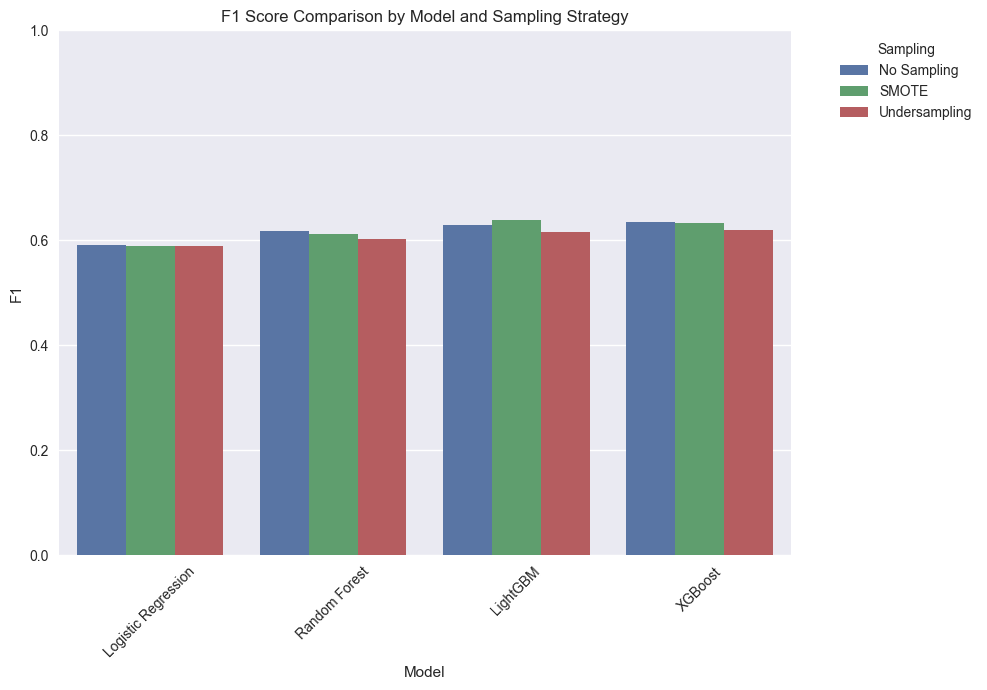

In [29]:
plt.figure(figsize=(10,7))
sns.barplot(x='Model', y='F1', hue='Sampling', data=df_plot)
plt.title("F1 Score Comparison by Model and Sampling Strategy")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.legend(title='Sampling', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

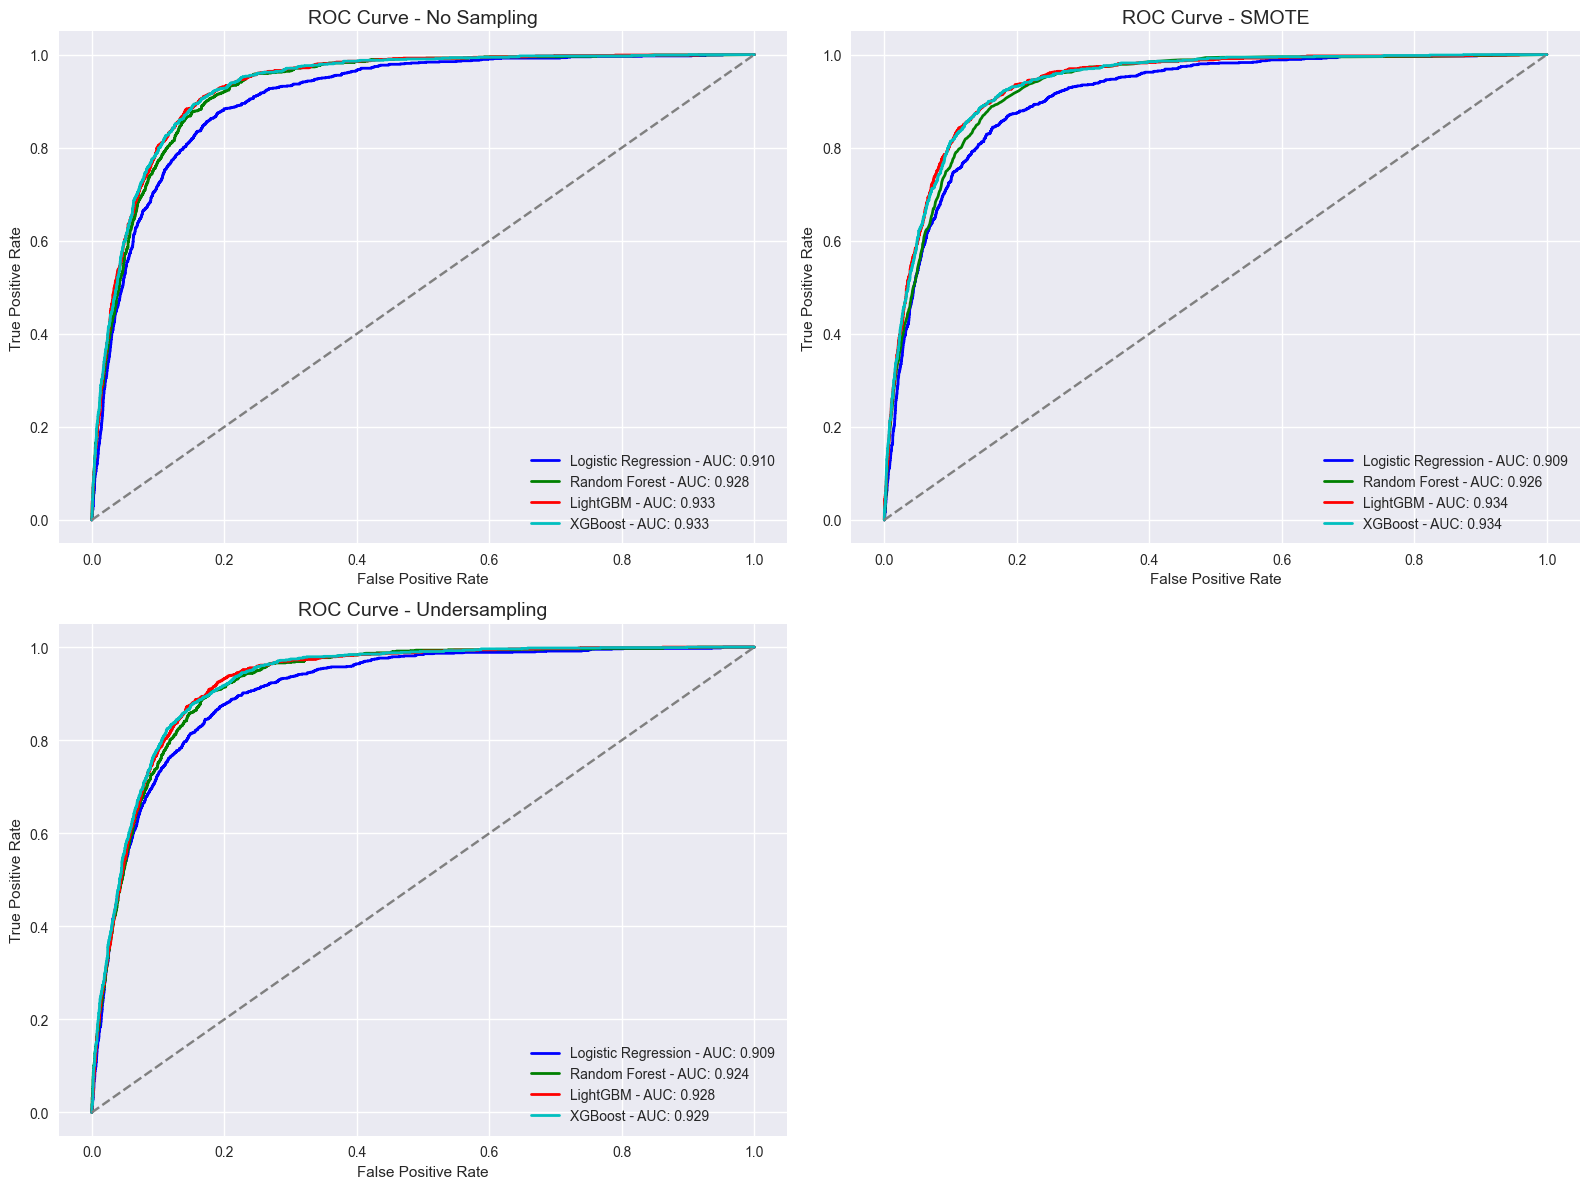

In [33]:

# Unique sampling methods
sampling_methods = df_plot['Sampling'].unique()

# Create subplots (2x2 grid for 4 methods)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Fixed colors per model
model_colors = {
    'Logistic Regression': 'b',
    'Random Forest': 'g',
    'LightGBM': 'r',
    'XGBoost': 'c'
}

# Sampling styles
sampling_styles = {
    'No Sampling': '-',
    'SMOTE': '-',
    'Undersampling': '-'
}

for ax, sampling in zip(axes, sampling_methods):
    df_subset = df_plot[df_plot['Sampling'] == sampling]

    for _, row in df_subset.iterrows():
        y_proba = all_results[row['Sampling']][row['Model']]['Probabilities']
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_area = auc(fpr, tpr)

        ax.plot(
            fpr, tpr,
            label=f"{row['Model']} - AUC: {roc_area:.3f}",
            color=model_colors.get(row['Model'], 'k'),   # fixed color per model
            linestyle=sampling_styles.get(row['Sampling'], '-'),  # style per sampling
            linewidth=2
        )

    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_title(f"ROC Curve - {sampling}", fontsize=14)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    ax.grid(True)

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


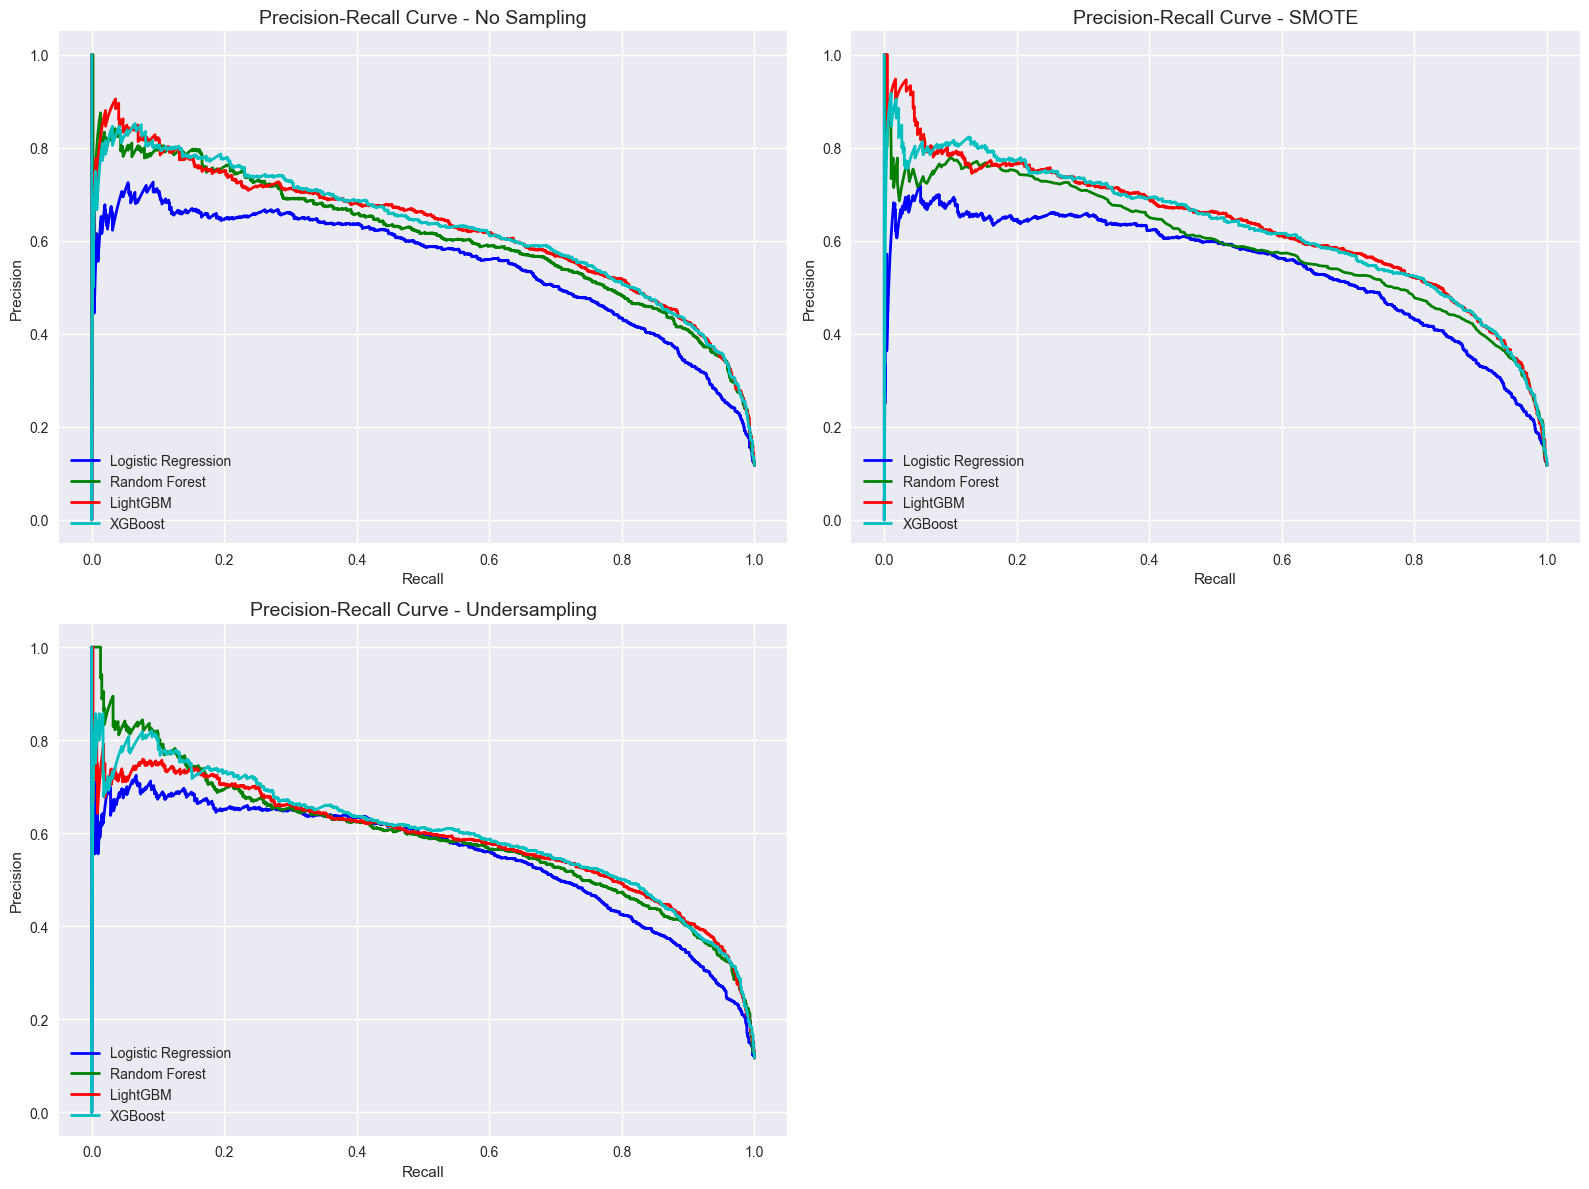

In [34]:

# Unique sampling methods
sampling_methods = df_plot['Sampling'].unique()

# Create subplots (2x2 grid for 4 methods)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Fixed colors per model
model_colors = {
    'Logistic Regression': 'b',
    'Random Forest': 'g',
    'LightGBM': 'r',
    'XGBoost': 'c'
}

for ax, sampling in zip(axes, sampling_methods):
    df_subset = df_plot[df_plot['Sampling'] == sampling]

    for _, row in df_subset.iterrows():
        y_proba = all_results[row['Sampling']][row['Model']]['Probabilities']
        precision, recall, _ = precision_recall_curve(y_test, y_proba)

        ax.plot(
            recall, precision,
            label=f"{row['Model']}",
            color=model_colors.get(row['Model'], 'k'),
            linewidth=2
        )

    ax.set_title(f"Precision-Recall Curve - {sampling}", fontsize=14)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc='lower left')
    ax.grid(True)


fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()


In [32]:
import pickle
# Find best model across all combinations
best_overall = {}
for sampling in all_results:
    for model in all_results[sampling]:
        key = f"{sampling}_{model}"
        best_overall[key] = all_results[sampling][model]['F1']

best_combo = max(best_overall, key=best_overall.get)
best_f1_score = best_overall[best_combo]
best_sampling, best_model_name = best_combo.split('_', 1)

print("BEST OVERALL MODEL:")
print(f"  Combination: {best_combo}")
print(f"  F1-Score: {best_f1_score:.3f}")

# Get the best model object
best_model_obj = all_results[best_sampling][best_model_name]['Best_Model']
best_threshold = all_results[best_sampling][best_model_name]['Best_Threshold']
best_probabilities = all_results[best_sampling][best_model_name]['Probabilities']
scaler = all_results[best_sampling][best_model_name]['Scaler']

# Model performance summary
best_results = all_results[best_sampling][best_model_name]
print("\nBEST MODEL PERFORMANCE:")
print(f"  Model: {best_model_name} with {best_sampling}")
print(f"  F1-Score: {best_results['F1']:.3f}")
print(f"  Precision: {best_results['Precision']:.3f}")
print(f"  Recall: {best_results['Recall']:.3f}")
print(f"  AUC: {best_results['AUC']:.3f}")
print(f"  Optimal Threshold: {best_results['Best_Threshold']:.3f}")

# Save best model
model_package = {
    'model': best_model_obj,
    'scaler': scaler,
    'threshold': best_threshold,
    'feature_names': list(X.columns),
    'model_info': {
        'name': best_model_name,
        'sampling': best_sampling,
        'f1_score': best_results['F1'],
        'precision': best_results['Precision'],
        'recall': best_results['Recall'],
        'auc': best_results['AUC']
    }
}

with open('../Models/best_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)
print("saved as 'best_model.pkl'")



BEST OVERALL MODEL:
  Combination: SMOTE_LightGBM
  F1-Score: 0.638

BEST MODEL PERFORMANCE:
  Model: LightGBM with SMOTE
  F1-Score: 0.638
  Precision: 0.556
  Recall: 0.749
  AUC: 0.934
  Optimal Threshold: 0.300
saved as 'best_model.pkl'
